Getting the number of relevant docs per query

In [5]:
from collections import defaultdict
from pathlib import Path

QRELS_PATH = Path("Data/qrels_50_Queries")

def count_relevant_per_query(qrels_path: Path):
    """
    Returns dict: topic -> number of relevant documents
    """
    rel_counts = defaultdict(int)

    with qrels_path.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) < 4:
                raise ValueError(f"Bad qrels format at line {line_no}: {line!r}")

            topic, _, _, rel = parts[:4]
            if int(rel) > 0:
                rel_counts[topic] += 1

    return dict(rel_counts)

Detecting Hard Queries:

In [7]:
for topic, cnt in sorted(rel_per_query.items(), key=lambda x: x[1]):
    print(f"Topic {topic}: {cnt}")


Topic 309: 3
Topic 308: 4
Topic 338: 4
Topic 344: 5
Topic 348: 5
Topic 320: 6
Topic 328: 8
Topic 334: 9
Topic 303: 10
Topic 339: 10
Topic 312: 11
Topic 327: 11
Topic 336: 12
Topic 310: 13
Topic 317: 14
Topic 342: 20
Topic 325: 24
Topic 316: 34
Topic 322: 34
Topic 305: 35
Topic 329: 35
Topic 345: 38
Topic 314: 44
Topic 326: 46
Topic 330: 60
Topic 323: 61
Topic 302: 65
Topic 333: 65
Topic 335: 66
Topic 315: 67
Topic 350: 68
Topic 340: 69
Topic 349: 73
Topic 341: 78
Topic 313: 93
Topic 337: 93
Topic 346: 105
Topic 318: 113
Topic 347: 152
Topic 324: 161
Topic 319: 170
Topic 311: 182
Topic 304: 196
Topic 321: 203
Topic 307: 210
Topic 331: 213
Topic 332: 254
Topic 343: 258
Topic 306: 332
Topic 301: 448


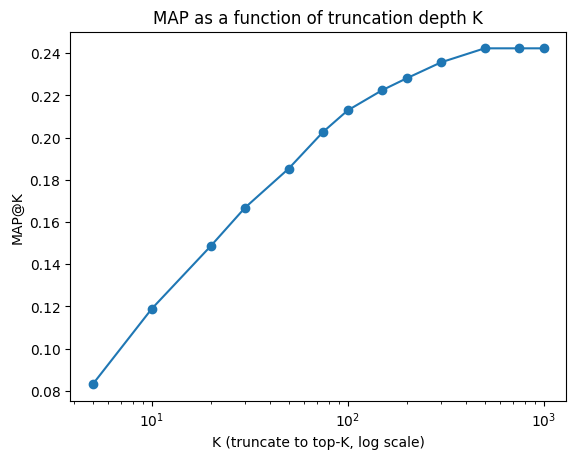

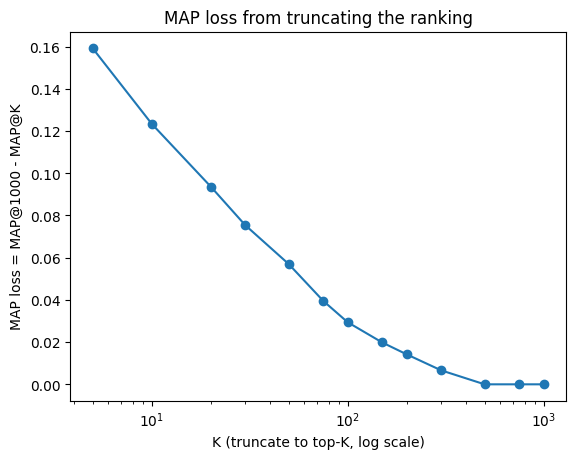

MAP@1000: 0.24225420721175706
K=   5  MAP@K=0.083070  loss=0.159184
K=  10  MAP@K=0.118816  loss=0.123438
K=  20  MAP@K=0.148540  loss=0.093714
K=  30  MAP@K=0.166826  loss=0.075428
K=  50  MAP@K=0.185255  loss=0.056999
K=  75  MAP@K=0.202686  loss=0.039568
K= 100  MAP@K=0.212832  loss=0.029422
K= 150  MAP@K=0.222409  loss=0.019845
K= 200  MAP@K=0.228046  loss=0.014208
K= 300  MAP@K=0.235630  loss=0.006625
K= 500  MAP@K=0.242254  loss=0.000000
K= 750  MAP@K=0.242254  loss=0.000000
K=1000  MAP@K=0.242254  loss=0.000000


In [3]:
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

RUN_PATH   = Path("Results/run.txt")  # <-- change to your res_i file

def read_qrels_relevant(qrels_path: Path):
    rel = defaultdict(set)  # topic -> {relevant docids}
    topics = set()
    with qrels_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            topic, _, docid, r = parts[:4]
            topics.add(topic)
            if int(r) > 0:
                rel[topic].add(docid)
    return rel, sorted(topics, key=int)

def read_run(run_path: Path):
    run = defaultdict(list)  # topic -> ranked docids (file order)
    with run_path.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 6:
                raise ValueError(f"Bad run format at line {line_no}: {line!r}")
            topic, _, docid, rank, score, tag = parts
            run[topic].append(docid)
    return run

def average_precision(ranked_docids, relevant_set):
    R = len(relevant_set)
    if R == 0:
        return 0.0
    hits = 0
    s = 0.0
    for k, d in enumerate(ranked_docids, start=1):
        if d in relevant_set:
            hits += 1
            s += hits / k
    return s / R

def MAP_at_K(run, rel, topics, K=None):
    aps = []
    for t in topics:
        ranked = run.get(t, [])
        if K is not None:
            ranked = ranked[:K]
        aps.append(average_precision(ranked, rel.get(t, set())))
    return sum(aps) / len(aps) if aps else 0.0

# ---- compute curve ----
rel, topics = read_qrels_relevant(QRELS_PATH)
run = read_run(RUN_PATH)

K_list = [5,10,20,30,50,75,100,150,200,300,500,750,1000]
map_1000 = MAP_at_K(run, rel, topics, K=1000)

map_at_k = [MAP_at_K(run, rel, topics, K=k) for k in K_list]
loss_at_k = [map_1000 - m for m in map_at_k]

plt.figure()
plt.plot(K_list, map_at_k, marker="o")
plt.xscale("log")
plt.xlabel("K (truncate to top-K, log scale)")
plt.ylabel("MAP@K")
plt.title("MAP as a function of truncation depth K")
plt.show()

plt.figure()
plt.plot(K_list, loss_at_k, marker="o")
plt.xscale("log")
plt.xlabel("K (truncate to top-K, log scale)")
plt.ylabel("MAP loss = MAP@1000 - MAP@K")
plt.title("MAP loss from truncating the ranking")
plt.show()

print("MAP@1000:", map_1000)
for k, m, l in zip(K_list, map_at_k, loss_at_k):
    print(f"K={k:4d}  MAP@K={m:.6f}  loss={l:.6f}")
